# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        
        #print(len(actions))
        
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
from ddpg_multiagent import Agent

import gym
import random

import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
%matplotlib inline

In [6]:
Agent.action_size = action_size
Agent.random_seed = 2

agent_0 = Agent(state_size=state_size, action_size=action_size, random_seed=2)
agent_1 = Agent(state_size=state_size, action_size=action_size, random_seed=2)

In [7]:
STOP_NOISE_AFTER_EP=300

def ddpg(n_episodes=5000, max_t=2000, num_agents=2):
    all_scores = []
    average = []
    scores_window = deque(maxlen=100)
    
    best_score = 0.0
    best_episode = 0
    
    add_noise = True
    
    for i_episode in range(1, n_episodes+1):
        
        if i_episode > STOP_NOISE_AFTER_EP:
            add_noise = False
        
        agent_0.reset()
        agent_1.reset()
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)

        while True:
            
            #print(len(states))
                        
            action_0 = agent_0.act(states[0], add_noise=add_noise)        
            action_1 = agent_1.act(states[1], add_noise=add_noise)            
            actions = np.concatenate((action_0, action_1), axis=0).flatten()
            
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            agent_0.step(states[0], action_0, rewards[0], next_states[0], dones[0])
            agent_1.step(states[1], action_1, rewards[1], next_states[1], dones[1])

            scores += rewards
            states = next_states
            
            if np.any(dones):                                   # exit loop if episode finished
                break
                
        max_score = np.max(scores)
        scores_window.append(max_score)
        all_scores.append(max_score)
        average.append(np.mean(scores_window))
        
        if max_score > best_score:
            best_score = max_score
            best_episode = i_episode
        
        print('\rEpisode {}\tAverage Score: {:.4f}\tMax Score: {:.4f}'.format(i_episode, np.mean(scores_window), np.max(all_scores)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}\tMax Score: {:.4f}'.format(i_episode, average[-1], np.max(all_scores)))
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        if i_episode > 100 and average[-1] >= 0.5:
            print('\nEnvironment solved in {:d} episodes! \tAverage Score: {:.4f}\tMax Score: {:.4f}'.format(i_episode, average[-1], np.max(all_scores)))
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break 
            
    return all_scores, average

In [8]:
scores = None
import workspace_utils
from workspace_utils import active_session

Episode 100	Average Score: 0.0019	Max Score: 0.1000
Episode 200	Average Score: 0.0000	Max Score: 0.1000
Episode 300	Average Score: 0.0075	Max Score: 0.2000
Episode 400	Average Score: 0.0215	Max Score: 0.2000
Episode 500	Average Score: 0.0154	Max Score: 0.2000
Episode 600	Average Score: 0.0455	Max Score: 0.3000
Episode 700	Average Score: 0.0780	Max Score: 0.3000
Episode 800	Average Score: 0.1051	Max Score: 0.4000
Episode 900	Average Score: 0.1872	Max Score: 0.7000
Episode 964	Average Score: 0.5011	Max Score: 2.6000
Environment solved in 964 episodes! 	Average Score: 0.5011	Max Score: 2.6000


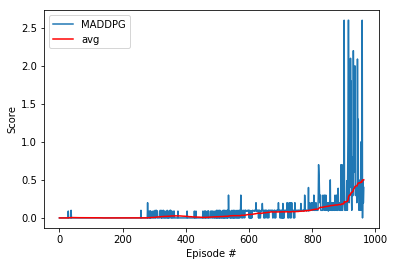

In [9]:
with active_session():
    scores, avgs = ddpg(n_episodes=3000)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='MADDPG')
    plt.plot(np.arange(len(scores)), avgs, c='r', label='avg')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(loc='upper left');
    plt.show()
    
    env.close()

## Agent and Neural Network architecture


I kept the model, agent and hyperparameters very close to what I used in project 2. I had to tweak a few things.

Most importantly the two agents share a replay buffer such that their experience is combined when training. I implemented it by making the instance of ReplayBuffer class static field in Agent class.

I decreased the value of the batch size to 128, which seemed to help by making the agent to learn faster.

The model for the actor has three fully connected layers with a rectified linear unit (ReLU) activation function on the first two layers and uses tanh after the third layer. First two layers are 512, 300 units in size. The first 2 layers use relu as activation functions and the final layer uses tanh.

The critic network uses 3 fully connected layers. This is down from 4 for the previous project. This seemed to help improve the speed of learning the value function. Layer 1 has 512 units, layer 2 has 300 units. Layer 1 and 2 use relu activation functions.

Noise was added using an Ornstein-Uhlenbeck process (as recommended in the paper) theta and sigma were set as the same values as the paper 0.15 and 0.2 respectively. I noticed that the agents struggled to learn after a certain amount of episodes and tried removing the noise. This improved learning significantly.




## Future Improvements

I've seen suggestions that others have had success with similar problems using using a Proximal Policy Optimization algorithm instead ddpg.

Another thing I'd like to train is share more information between agents. For example having the actor networks sync weights (I was thinking throught averaging them) after a certain amount of episodes.

In [1]:
""" Source:
      - https://stackoverflow.com/questions/48122744/how-to-download-all-files-and-folder-hierarchy-from-jupyter-notebook
"""
import os
import tarfile

def recursive_files(dir_name='.', ignore=None):
    for dir_name,subdirs,files in os.walk(dir_name):
        if ignore and os.path.basename(dir_name) in ignore:
            continue

        for file_name in files:
            if ignore and file_name in ignore:
                continue

            yield os.path.join(dir_name, file_name)

def make_tar_file(dir_name='.', target_file_name='workspace_archive.tar', ignore=None):
    tar = tarfile.open(target_file_name, 'w')

    for file_name in recursive_files(dir_name, ignore):
        tar.add(file_name)

    tar.close()


dir_name = '.'
target_file_name = 'workspace_archive.tar'
# List of files/directories to ignore
ignore = {'.ipynb_checkpoints', '__pycache__', target_file_name}

make_tar_file(dir_name, target_file_name, ignore)